In [1]:
import sys
import shapely
from shapely.geometry import box, MultiPolygon, LineString, Point, MultiLineString, Polygon
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from gridmap import OccupancyGridMap
import matplotlib.pyplot as plt
from a_star import a_star
from utils import plot_path
from sklearn import preprocessing
import pandas as pd
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
import random
from tqdm import tqdm
import imageio

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_points_on_circ = 4
pi = math.pi
def PointsInCircum(r,n=num_points_on_circ, center = (0,0)):
    return np.array([(center[0] + math.cos(2*pi/n*x)*r, center[1] + math.sin(2*pi/n*x)*r) for x in range(0,n+1)])

In [3]:
def gen_shapely_map(map_size, obstacles):
    '''
    Given map_size and list of obstacles where
    an obstacle is described by a tuple (xmin, ymin, xmax, ymax),
    create a shapely map. 
    '''
    
    pols = [box(0,0,map_size[0], map_size[1])]
    for obstacle in obstacles:
        pols.append(box(*obstacle))
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return MAP

def get_map_arr(MAP_params, shape):
    '''
    Convert the shapely obstacles into a numpy grid
    for use with the A* planner. 
    
    MAP_params is of the form [(xmin, ymin, xmax, ymax), (xmin, ymin, xmax, ymax), ...]
    describing each rectangular obstacle in the map. Currently only supports rectangles. 
    
    Shape is just a tuple with the map size. 
    
    '''
    map_np = np.zeros(shape)
    for param in MAP_params:
        xmin, ymin, xmax, ymax = param
        map_np[ymin:ymax, xmin:xmax] = 1
        
    return map_np

In [4]:
# Mapping from label encoder (just hard coded it here)
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
inv_dirs = {d: label for label, d in dirs.items()}

In [5]:
# 4n = 4 point connectivity. 8N = 8 point connectivity
def synthetic_sensor(MAP, robot_location, direction, movement='4N'):
    '''
    Given a shapely map and the robots current location, 
    return the 360 degree laser scanner. 
    '''
    lines = []
    # 100 is arbitrary radius. Just needs to be big enough to draw line across map. 
    points = PointsInCircum(100, center = robot_location)
    # Create line to all points on circle
    for point in points:
        A = Point(robot_location)
        B = Point(point)
        line = LineString([A,B])
        lines.append(line)
    # Get points of intersection. 
    for i, line in enumerate(lines):

        # These two types of objects signify multiple intersections. 
        if type(MAP.intersection(line)) == shapely.geometry.multilinestring.MultiLineString or \
               type(MAP.intersection(line)) == shapely.geometry.multipoint.MultiPoint:
            # Get the closest point
            temp_dist = []
            for point in MAP.intersection(line):
#                 try:
                temp_dist.append(LineString([robot_location, point]).length)
            inter = MAP.intersection(line)[np.argmin(temp_dist)]
        # This signifies no intersection. Wont happen on current map. 
        elif type(MAP.intersection(line)) == shapely.geometry.collection.GeometryCollection:
            cp = MAP.intersection(line)[0] 
            lines[i].coords = [robot_location, cp]
            continue
        # One intersection
        else:
            inter = MAP.intersection(line)
        # Create new point and update end point in list of lines. 
        new_point = (inter.xy[0][0], inter.xy[1][0])
        lines[i].coords = [robot_location, new_point]
    
    # Get lase scan data (distances)
    distances = [line.length for line in lines][:num_points_on_circ]
    # Account for robot orientation
    if direction != (0, 0): # Start node
        if movement == '4N':
            offset = int(len(distances) / 4.) * inv_dirs[direction]
        else: 
            offset = int(len(distances) / 8.) * inv_dirs[direction]
        distances = distances[offset:] + distances[:offset]  
    return distances, lines
    

In [6]:
def plot(MAP, robot_location, line_strings = None, plot_lines=False):
    '''
    This plot function is used to show the laser scan lines. 
    Current not used. Probably will be helpful when creating visualizations. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(50,50)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    if plot_lines:
        for line in line_strings:
            ax.plot(*line.xy, alpha=0.25)
    ax.scatter(*robot_location, s=30, alpha=1.0)

In [7]:
def get_path(start, goal, arr, plot = True):
    '''
    Given start (x,y) and goal (x,y) use numpy grid arr
    to solve for best path with A*. 
    
    By default, plot the A* path everytime this is called. 
    '''
    resolution = 1
    gmap = OccupancyGridMap(arr, resolution)

    # 4n = 4 point connectivity. 8N = 8 point connectivity
    path, path_px = a_star(start, goal, gmap, movement='4N')
    if plot:
        gmap.plot()
        plot_path(path_px)
    return path

In [8]:
def plot_path_(MAP, robot_location, goal_location, path):
    '''
    Plot path on map using shapely. Not currently used. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(6,6)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    
    ax.plot(*LineString(path).xy)
    ax.scatter(robot_location[0], robot_location[1], s=30, alpha=1.0) 
    ax.scatter(goal_location[0], goal_location[1], s=30, alpha=1.0) 

In [56]:
def synthesize_data(start, goal, MAP, map_arr, polar=False):
    '''
    synthesize data for one step. 
    
    -Given start and goal, we first get the A* ground truth path. 
    -If get_path() returns an error, that means there was no path found. 
    -For each element in the path, use the synthetic sensor to get the readings 
        the relative goal in odom, and the target movement
    '''
    
    # Get path if one is available
    try:
        path = get_path(start, goal, map_arr, False)
    except:
        return
    
    sensor_readings = []
    relative_goals = []
    polar_goals = [] # Polar coordinates used by paper
    directions = []
    steering = []
    prev = start
    for i, loc in enumerate(path):
        # Get direction to next cell
        direction = (loc[0] - prev[0], loc[1] - prev[1])
        # Get rotation
        offset = 0
        if direction != (0, 0): # Start node
            offset = inv_dirs[direction]
        rot = np.pi/2 * offset
        # Get laser scan
        ls,_ = synthetic_sensor(MAP, (loc[0]+0.5, loc[1]+0.5), direction)
        sensor_readings.append(ls)
        # Get goal in odom
        goal_loc = (goal[0]-loc[0], goal[1]-loc[1])  
        # Get goal in odom
        goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
        relative_goals.append(goal_orn)   
#         relative_goals.append(goal_loc)
        
        # Get polar distance
        polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
        # Get polar rotation
        polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
        polar_goals.append((polar_distance, polar_rotation))
        
        # Get relative steering
        if len(directions) > 1:
            ds = inv_dirs[direction] - inv_dirs[directions[len(directions)-1]]
        elif len(directions) == 1: # First node after start
            ds = inv_dirs[direction]
        else: ds = 0 # Start node
        steering.append(ds)
        
        # Get movement to next cell
        directions.append(direction)
        
        prev=loc
    
    # Return polar goals if True
    if polar:
        return np.array(sensor_readings), np.array(polar_goals), directions, path
    return np.array(sensor_readings), np.array(relative_goals), directions, path

In [57]:
def synthesize_train_set(MAPs, num_runs = 5):
    '''
    -Get 'num_runs' different start/goal locations inside the map
    -If path is available, get training data for a given path
    -Return pandas dataframe where first 360 columns are sensor data, cols
     361 and 362 are odom info and then last 2 columns are x,y movement directions. 
    '''
    
    df = []
    print("??")
    for i in range(num_runs):
        # TODO: Generalize to any map shape
        start = (random.randint(1,49), random.randint(1,49))
        goal = (random.randint(1,49), random.randint(1,49))
        MAP, map_arr = random.choice(MAPs)
        # If path is available, get training info
        try:
            (sensor_readings, relative_goals, directions, path) = synthesize_data(start, goal, MAP, map_arr)
            print("???")
#             print(relative_goals.shape, steering.shape)
            train = np.concatenate((sensor_readings, relative_goals, directions), axis=1)
#             df.append(train)
        except:
            # No path found
            continue
    return pd.DataFrame(np.vstack(df))


In [58]:
map_size = (50,50)
MAPS = []
for i in range(2):
    arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    MAPS.append((train_MAP,arr))

test = synthesize_train_set(MAPS, num_runs = 10)

??
???
???
???
???
???


ValueError: need at least one array to concatenate

In [38]:
def make_tuple(x):
    '''
    Function used to turn 2 pandas columns into
    a tuple in one column. See create_classification_problem
    for use. 
    '''
    return (x.iloc[0], x.iloc[1])

def get_inv_dirs(x):
    '''
    Function to encode direction tuple according to hard-coded encoding
    '''
    return inv_dirs[x]

def create_classification_problem(df, one_hot = False):
    '''
    Now that training data has been synthesized, 
    prepare data for use with ML model. 
    '''
    
    # Turn (x,y) target into into string tuple
    # so we can then use label encoding to turn
    # this into a classification problem. 
    df['out'] = df[[num_points_on_circ+2,num_points_on_circ+3]].apply(make_tuple, axis=1)
#     df['out'] = df['out'].astype(str)
    
    # Drop the sample where we are at the target location. 
    # We don't want to learn to stay still. 
#     df = df[df['out']!='(0.0, 0.0)']
    df = df[df['out']!=(0.0, 0.0)]
 
    # Label encode targets
#     enc = preprocessing.LabelEncoder()
#     df['out'] = enc.fit_transform(df['out'])
    df['out'] = df['out'].apply(get_inv_dirs)
    
    # Added one-hot encoding option which
    # may be neccessary for some models
    if one_hot:
        ohe = preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(df['out'].values.reshape(-1,1)) 
        df['out'] = df['out'].apply(lambda x : ohe.transform(x))
        df['out'] = df['out'].apply(lambda x : x[0])
    
    # Drop the (x,y) target columns, which have now
    # been label encoded. 
    df.drop([num_points_on_circ+2, num_points_on_circ+3], axis=1, inplace=True)
    
    return df


In [12]:
def quadFits(map_np, sx, sy, rx, ry, margin):
        """
        looks to see if a quad shape will fit in the grid without colliding with any other tiles
        used by placeRoom() and placeRandomRooms()
         
        Args:
            sx and sy: integer, the bottom left coords of the quad to check
            rx and ry: integer, the width and height of the quad, where rx > sx and ry > sy
            margin: integer, the space in grid cells (ie, 0 = no cells, 1 = 1 cell, 2 = 2 cells) to be away from other tiles on the grid
             
        returns:
            True if the quad fits
        """
         
        sx -= margin
        sy -= margin
        rx += margin*2
        ry += margin*2
        if sx + rx < np.size(map_np, axis=1) and sy + ry < np.size(map_np, axis=0) and sx >= 0 and sy >= 0:
            for x in range(rx):
                for y in range(ry):
                    if map_np[sy+y, sx+x]: 
                        return False
            return True
        return False
    
def placeRandomRooms(map_size, minRoomSize, maxRoomSize, roomStep = 1, margin = 1, attempts = 500):
    """ 
    randomly places quads in the grid
    takes a brute force approach: randomly a generate quad in a random place -> check if fits -> reject if not
    Populates self.rooms

    Args:
        minRoomSize: integer, smallest size of the quad
        maxRoomSize: integer, largest the quad can be
        roomStep: integer, the amount the room size can grow by, so to get rooms of odd or even numbered sizes set roomSize to 2 and the minSize to odd/even number accordingly
        margin: integer, space in grid cells the room needs to be away from other tiles
        attempts: the amount of tries to place rooms, larger values will give denser room placements, but slower generation times

    Returns:
        none
    """
    
    pols = [box(0,0,map_size[0], map_size[1])]
    map_np = np.zeros(map_size)
    
    for attempt in range(attempts):
        roomWidth = random.randrange(minRoomSize, maxRoomSize, roomStep)
        roomHeight = random.randrange(minRoomSize, maxRoomSize, roomStep)
        startX = random.randint(0, map_size[1])
        startY = random.randint(0, map_size[0])            
        if quadFits(map_np, startX, startY, roomWidth, roomHeight, margin):
            for x in range(roomWidth):
                for y in range(roomHeight):
                    map_np[startY+y, startX+x] = 1
            pols.append(box(startX, startY, startX+roomWidth, startY+roomHeight))
    
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return map_np, MAP

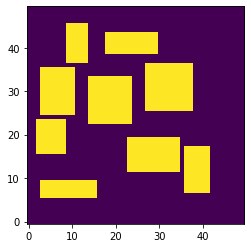

In [13]:
# synthetic_sensor & synthesize_data test
map_size = (50,50)
arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
OccupancyGridMap(arr, 1).plot()

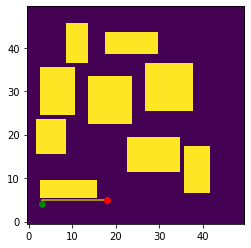

0
location: (18, 5)
direction: (0, 0)
steering: [0]
laserscan: [32.0, 18.0, 18.0, 5.0]
polar (15.033296378372908, -176.18592516570965)
relative goal (-15.0, -1.0)

1
location: (17, 5)
direction: (-1, 0)
steering: [0, 2]
laserscan: [17.0, 5.0, 33.0, 18.0]
polar (14.035668847618199, 4.085616779974884)
relative goal (14.0, 1.0000000000000018)

2
location: (16, 5)
direction: (-1, 0)
steering: [0, 2, 0]
laserscan: [16.0, 5.0, 34.0, 18.0]
polar (13.038404810405298, 4.398705354995538)
relative goal (13.0, 1.0000000000000016)

3
location: (15, 5)
direction: (-1, 0)
steering: [0, 2, 0, 0]
laserscan: [15.0, 5.0, 35.0, 1.0]
polar (12.041594578792296, 4.7636416907261845)
relative goal (12.0, 1.0000000000000016)

4
location: (14, 5)
direction: (-1, 0)
steering: [0, 2, 0, 0, 0]
laserscan: [14.0, 5.0, 36.0, 1.0]
polar (11.045361017187261, 5.194428907734813)
relative goal (11.0, 1.0000000000000013)

5
location: (13, 5)
direction: (-1, 0)
steering: [0, 2, 0, 0, 0, 0]
laserscan: [13.0, 5.0, 37.0, 1.0]
p

In [30]:
start = (18, 5)
goal = (3, 4)
path = get_path(start, goal, arr, plot = True)

sensor_readings = []
relative_goals = []
polar_goals = [] # Polar coordinates used by paper
directions = []
steering = []

prev = start
    
for i, loc in enumerate(path):
    # Get direction to next cell
    direction = (loc[0] - prev[0], loc[1] - prev[1])
    # Get rotation
    offset = 0
    if direction != (0, 0): # Start node
        offset = inv_dirs[direction]
    rot = np.pi/2 * offset
    # Get laser scan
    ls,_ = synthetic_sensor(train_MAP, (loc[0], loc[1]), direction)
    sensor_readings.append(ls)
    # Get goal in odom
    goal_loc = (goal[0]-loc[0], goal[1]-loc[1])  
    # Get goal in odom
    goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
    relative_goals.append(goal_orn)   
#         relative_goals.append(goal_loc)

    # Get polar distance
    polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
    # Get polar rotation
    polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
    
    polar_goals.append((polar_distance, polar_rotation / np.pi * 180.))
    
    # Get relative steering
    if len(directions) > 1:
        ds = inv_dirs[direction] - inv_dirs[directions[len(directions)-1]]
    elif len(directions) == 1: # First node after start
        ds = inv_dirs[direction]
    else: ds = 0 # Start node
    steering.append(ds)

    # Get movement to next cell
    directions.append(direction)
    prev=loc
    
    # Print
    print(i)
    print('location:', loc)
    print('direction:', direction)
    print('steering:', steering)
    print('laserscan:', ls)
    print('polar', polar_goals[i])
    print('relative goal', goal_orn)
    print()

In [59]:
0%2

0

In [44]:
# Get trainning data
map_size = (50,50)
MAPS = []
for i in range(50):
    arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    MAPS.append((train_MAP,arr))

df_ = synthesize_train_set(MAPS, num_runs = 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.10it/s]


ValueError: need at least one array to concatenate

In [73]:
# Prep data for modeling
df = create_classification_problem(df_.copy()) 
# Shuffle data (otherwise model can cheat and memorize order since these are no iid)
df = df.sample(frac=1)

# df = pd.read_csv('500_multimap2.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)

In [74]:
print(cross_val_score(RandomForestClassifier(), df.drop(['out'], axis=1).values, df['out'].values, cv=3, scoring = 'f1_micro'))
# Fit model using all data.
clf = RandomForestClassifier(n_estimators=150, max_depth=36)
# df.drop(0, axis=0, inplace=True)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

[0.83659218 0.82212885 0.84431978]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
from copy import deepcopy
'''
Testing Env:

Now we use trained model to nav unseen map. 
'''

# Mapping from label encoder (just hard coded it here)
# dirs = {0:(-1.0, 0.0), 1:(0.0, -1.0), 2:(0.0, 1.0), 3:(1.0, 0.0)}
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}

map_params = [(5,8,18,23), (45,0,50,12), (10,10,15,15), (25,20,35,25), (44,44,49,49), (31,38,40,40), (30,10,39,19), (15,25,28,30), (30,30,35,35),(0,45,10,46), (20,30,5,35)]
map_size = (50,50)
# Gen training map
test_MAP = gen_shapely_map(map_size, map_params)
# Convert to numpy array for A*
arr = get_map_arr(map_params, map_size)

def test_on_new_map(_MAP, test_arr, start, goal, model):
    
    '''
    Test model performance on unseen map. 
    
    test_MAP = shapely map
    test_arr = numpy grid of mapll
    
    start,goal = (x,y), (x,y)
    model = trained sklearn model 
    '''
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]
    cur_dir = (0, 0) # Get robot direction
    cur = start
    while cur != goal:
        try:
            # Get the laser_scan data for the current point
#             cur = (cur[0]+1, cur[1]+1)
            laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir)
            laser_scan.append(goal[0]-cur[0])
            laser_scan.append(goal[1]-cur[1])
            # Create model input
            inpX = np.array(laser_scan)
            print(inpX)
            # Get predicted direction
            inds = model.predict_proba(inpX.reshape(1,-1))[0]
            best = list(np.argsort(inds))
            best.reverse()
            
            possible_next_states = [(cur[0] + dirs[ind][0], cur[1] + dirs[ind][1]) for ind in best]
            temp_states = deepcopy(possible_next_states)
            for state in possible_next_states:
                if (-1 in state) or (50 in state) or (0 in state) or (state in pred_path):
                    temp_states.remove(state)

            # Update state
            cur_dir = (temp_states[0][0] - cur[0], temp_states[0][1] - cur[1])
            cur = temp_states[0]
            
            assert cur not in pred_path
            pred_path.append(cur)
            # Cout number of steps traveled 
            i+=1
            if i==100 or cur == goal:
                break
        except:
            break
    
    return pred_path 
    

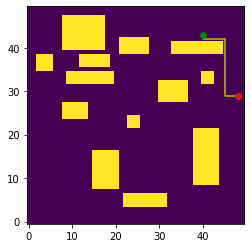

Number of steps taken in A* Path,  23
[ 1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983 14.35015835 20.52813309
 20.5        20.52813309 20.61291973 20.75553508 20.95798219 21.2231617
 11.32623792 10.17587744 10.39904465 10.66209926 10.96965511 11.32745128
 11.74264579 12.22421588 12.78351093  7.77817459  7.40098001  7.07717761
  6.79837388  6.55799811  6.35085296  6.17279431  6.14648334  6.97607027
  8.09016994 11.90567607 11.75691684 11.64334895 11.56334521 11.51578198
 11.5        11.51578198 11.56334521 34.93004684 23.00266338 23.29371406
 23.65790005 34.88035137 30.73241669 30.86397153 31.75426481 32.78999055
 12.75976213 11.91761797 11.20857412 10.60660172 10.09224547  9.65069674
  9.27050983  

[21.5        21.52950544 14.35015835  9.58867983  7.21460152  5.79555496
  4.85410197  4.18564216  3.68789     3.3040339   3.          2.75411769
  2.55195243  2.38352359  2.24171482  2.12132034  2.01844909  1.93013935
  1.85410197  1.78854494  1.73205081  1.68348936  1.64195442  1.60671749
  1.57719334  1.55291427  1.53351089  1.51869769  1.50826242  1.50205852
  1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983 14.35015835 28.53911186
 28.5        28.53911186 28.65698597 28.85525608 17.89096041 18.11733316
 18.40058892 18.74503739 13.52226335 12.11479096 12.12435565 12.51981457
 12.97871376 22.5182924  38.35053279 28.99137803 15.47477639 14.79773501
 14.21478174 13.71217787 13.27905619 14.31748022 15

[15.5        15.52127136 14.35015835  9.58867983  7.21460152  5.79555496
  4.85410197  4.18564216  3.68789     3.3040339   3.          2.75411769
  2.55195243  2.38352359  2.24171482  2.12132034  2.01844909  1.93013935
  1.85410197  1.78854494  1.73205081  1.68348936  1.64195442  1.60671749
  1.57719334  1.55291427  1.53351089  1.51869769  1.50826242  1.50205852
  1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983 14.35015835 28.66098391
 34.5        34.54734594 34.69003564 23.79293046 24.02500398 24.32899024
 17.79837388 17.6738924  18.0614986  18.51838292 27.13546265 28.02053738
  7.65585728  7.15057078  6.72514447  6.36396103  6.05534728  5.79041805
  5.5623059   5.36563482  5.19615242  5.05046807  4

[ 9.5         9.51303729  9.55232866  9.58867983  7.21460152  5.79555496
  4.85410197  4.18564216  3.68789     3.3040339   3.          2.75411769
  2.55195243  2.38352359  2.24171482  2.12132034  2.01844909  1.93013935
  1.85410197  1.78854494  1.73205081  1.68348936  1.64195442  1.60671749
  1.57719334  1.55291427  1.53351089  1.51869769  1.50826242  1.50205852
  1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983 14.35015835 28.66098391
 40.5        40.55558001 40.72308532 29.86772121 30.15904755 23.29371406
 23.65790005 12.55692649 11.06367001  9.91210169  9.          8.26235306
  7.65585728  7.15057078  6.72514447  6.36396103  6.05534728  5.79041805
  5.5623059   5.36563482  5.19615242  5.05046807  4

[ 3.5         3.50480321  3.51927898  3.54362794  3.57819208  3.62346663
  3.68011778  3.74900748  3.68789     3.3040339   3.          2.75411769
  2.55195243  2.38352359  2.24171482  2.12132034  2.01844909  1.93013935
  1.85410197  1.78854494  1.73205081  1.68348936  1.64195442  1.60671749
  1.57719334  1.55291427  1.53351089  1.51869769  1.50826242  1.50205852
  1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983 14.35015835 28.66098391
 46.5        46.56381409 35.69554392 35.94251197 29.13670695 17.38666487
 14.5623059  12.55692649 11.06367001  9.91210169  9.          8.26235306
  7.65585728  7.15057078  7.40098001  7.77817459  8.21962102  8.73958651
  9.35715889 10.09843152 11.         45.15512992 30

[45.5        45.56244174 34.69003564 28.7660395  16.83407021 13.52296157
 11.32623792  9.76649838  8.60507667  7.70941243  7.          6.42627461
  5.95455566  5.79041805  6.05534728  6.36396103  6.72514447  7.15057078
  7.65585728  8.26235306  9.          9.91210169 29.00786138 28.38534233
 27.86374894 27.43481878 27.09202576 15.69320945 15.58537833 15.52127136
 15.5        47.56518643 43.05047505 28.7660395  21.64380455 17.38666487
 14.5623059  12.55692649 11.06367001  9.91210169  9.          8.26235306
  7.65585728  7.15057078  6.72514447  6.36396103  6.05534728  5.79041805
  5.5623059   5.36563482  5.19615242  5.05046807  4.92586325  4.82015247
  4.73158001  4.65874281  4.60053268  4.55609307  4.52478726  4.50617556
  4.5         4.50617556  4.52478726  4.55609307  4.60053268  4.65874281
  4.73158001  4.82015247  4.92586325  5.05046807  5.          4.59019615
  4.25325404  3.97253932  3.73619137  3.53553391  3.36408182  3.21689891
  3.09016994  2.98090823  2.88675135  2.80581559  2

[44.5        12.51715432 12.56885349 12.65581407 12.77925744 12.94095226
 24.27050983 20.92821082 18.43945002 16.52016948 15.         13.77058844
 12.75976213 11.91761797 11.20857412 10.60660172 10.09224547  9.65069674
  9.27050983  8.9427247   8.66025404  8.41744678  8.20977209  8.03358745
  7.88596668  7.76457135  7.66755446  7.59348844  7.5413121   7.51029259
  7.5         7.51029259  7.5413121   7.59348844  7.66755446  7.76457135
  7.88596668  8.03358745  8.20977209  8.41744678  8.66025404  8.9427247
  9.27050983  8.73958651  8.21962102  7.77817459  7.40098001  7.07717761
  6.79837388  6.55799811  6.35085296  6.17279431  6.02049953  5.89129747
  5.78304223  5.69401899  5.62287327  5.56855819  5.53029554  5.5075479
  5.5         5.5075479   5.53029554  5.56855819  5.62287327  5.69401899
  5.78304223  5.89129747  6.02049953  6.17279431  6.35085296  6.55799811
  6.79837388  7.07717761  7.40098001  7.77817459  8.21962102  8.73958651
  9.35715889 10.09843152 11.         12.11479096 13.5

 -2.         37.        ]
[ 5.5         5.5075479   5.53029554  5.56855819  5.62287327  5.69401899
  5.78304223  5.89129747  6.02049953  6.17279431  6.35085296  6.55799811
  6.79837388  7.07717761  7.40098001  7.77817459  8.21962102  8.73958651
  9.27050983  8.9427247   8.66025404  8.41744678  8.20977209  8.03358745
  7.88596668  7.76457135  7.66755446  7.59348844  7.5413121   7.51029259
  7.5         7.51029259  7.5413121   7.59348844  7.66755446  7.76457135
  7.88596668  8.03358745  8.20977209  8.41744678  8.66025404  8.9427247
  9.27050983  9.65069674 10.09224547 10.60660172 11.20857412 11.91761797
 12.75976213 13.77058844 15.         16.52016948 18.43945002  3.74900748
  3.68011778  3.62346663  3.57819208  3.54362794  3.51927898  3.50480321
  3.5         3.50480321  3.51927898  3.54362794  3.57819208  3.62346663
  3.68011778  3.74900748  3.83122697  3.92814183  4.04145188  4.17327152
  4.32623792  4.50365848  4.70971455  4.94974747  5.23066792  5.56155505
 35.22793736 33.98235385 3

[ 1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.69401899  5.62287327  5.56855819  5.53029554  5.5075479
  5.5         5.5075479   5.53029554  5.56855819  5.62287327  5.69401899
  5.78304223  5.89129747  6.02049953  6.17279431  6.35085296  6.55799811
  6.79837388  7.07717761  7.40098001  7.77817459  8.21962102  8.73958651
  9.35715889 10.09843152 11.         12.11479096 13.52226335 15.3473546
 17.79837388 21.25036818 26.4535389  35.15849272 48.76715156 48.56655878
 37.5         9.5536613   7.5413121   7.59348844  7.66755446  7.76457135
  7.88596668  8.03358745  8.20977209  8.41744678  8.66025404  8.9427247
  9.27050983  9.65069674 27.64781617 28.99137803 45.58153477 39.24616676
 38.27928638 28.02053738 27.13546265 26.37466658 25.72

[40.5        28.66098391 14.35015835  9.58867983  7.21460152  5.79555496
  4.85410197  4.18564216  3.68789     3.3040339   3.          2.75411769
  2.55195243  2.38352359  2.24171482  2.12132034  2.01844909  1.93013935
  1.85410197  1.78854494  1.73205081  1.68348936  1.64195442  1.60671749
  1.57719334  1.55291427  1.53351089  1.51869769  1.50826242  1.50205852
  1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983  9.55232866  9.51303729
  9.5         9.51303729  9.55232866  9.61841869  9.71223565  9.83512371
  9.98889113 10.17587744 10.39904465 10.66209926 10.96965511 11.32745128
 11.74264579 12.22421588 12.78351093 13.43502884 14.19752722 15.09564943
 16.16236536 17.44274536 19.         20.92554801  8

[37.5        37.55146297 23.91693058 15.98113305 12.02433586  9.65925826
  8.09016994  6.97607027  6.14648334  5.50672316  5.          4.59019615
  4.25325404  3.97253932  3.73619137  3.53553391  3.36408182  3.21689891
  3.09016994  2.98090823  2.88675135  2.80581559  2.7365907   2.67786248
  2.62865556  2.58819045  2.55585149  2.53116281  2.5137707   2.50343086
  2.5         2.50343086  2.5137707   2.53116281  2.55585149  2.58819045
  2.62865556  2.67786248  2.7365907   2.80581559  2.88675135  2.98090823
  3.09016994  3.21689891  3.36408182  3.53553391  3.73619137  3.97253932
  4.25325404  4.59019615  5.          5.50672316  6.14648334  6.97607027
  8.09016994  9.65925826 12.02433586 12.65581407 12.56885349 12.51715432
 12.5        12.51715432 12.56885349 12.65581407 12.77925744 12.94095226
 13.1432778  13.38931242 13.68295348 14.02907797 14.43375673 14.90454116
 15.45084972 16.08449457 16.82040912  9.19238816  8.74661274  8.36393718
  8.03444185  7.7503614   7.5055535   7.29512054  7

[22.5        22.53087778 22.62393629 22.78046533 23.00266338 23.29371406
 35.22398451 35.88335729 36.67031533 40.74975139 21.         19.67399433
 20.39512163 21.23153284 35.65926733 37.4766594  30.27673642 29.39679099
 19.15905365 18.48163104 17.89785834 17.39605668 16.96686232 16.6027474
  4.73158001  4.65874281  4.60053268  4.55609307  4.52478726  4.50617556
  4.5         4.50617556  4.52478726  4.55609307  4.60053268  4.65874281
  4.73158001 15.3473546  13.52226335 12.11479096 11.         10.09843152
  9.35715889  8.73958651  8.21962102  7.77817459  7.40098001  7.07717761
  6.79837388  6.55799811  6.35085296  6.17279431  6.02049953  5.89129747
  5.78304223  5.69401899  5.62287327  5.56855819  5.53029554  5.5075479
  5.5         5.5075479   5.53029554  5.56855819  5.62287327  5.69401899
  5.78304223  5.89129747  6.02049953  6.17279431  6.35085296  6.55799811
  6.79837388  7.07717761  7.40098001  7.77817459  8.21962102  8.73958651
  9.35715889 10.09843152 11.         12.11479096 13.5

[14.5        14.51989902 14.57987005 14.68074432 36.29309112 13.52296157
 11.32623792  9.76649838  8.60507667  7.70941243  7.          6.42627461
  5.95455566  5.56155505  5.23066792  4.94974747  5.23066792  5.56155505
  5.95455566  6.42627461  7.         11.7844255  11.49368092 11.24702243
 11.04035335 10.87039989 10.73457625 10.63088382 10.55783694 10.51440963
 10.5        10.51440963 10.55783694 10.63088382 10.73457625 10.87039989
 11.04035335 11.24702243 11.49368092 11.7844255  12.12435565 12.51981457
 12.97871376 13.51097544 14.12914366 14.8492424  15.69200377 16.68466516
 17.86366698 17.28926775  2.88675135  2.80581559  2.7365907   2.67786248
  2.62865556  2.58819045  2.55585149  2.53116281  2.5137707   2.50343086
  2.5         2.50343086  2.5137707   2.53116281  2.55585149  2.58819045
  2.62865556  2.67786248  2.7365907   2.80581559  2.88675135  2.98090823
  3.09016994  3.21689891  3.36408182  3.53553391  3.73619137  3.97253932
  4.25325404  4.59019615  5.          5.50672316  6

[ 7.5         7.51029259  7.5413121   7.59348844  7.66755446  7.76457135
  7.88596668  8.03358745  8.20977209  8.41744678  8.66025404  8.9427247
  9.27050983  9.65069674 10.09224547 10.60660172 11.20857412 11.91761797
 12.75976213 13.77058844 15.         16.52016948 16.96686232 16.6027474
 16.29766448 16.0467808  15.84627922 15.69320945 15.58537833 15.52127136
 15.5        15.52127136 15.58537833  9.58867983  7.21460152  5.79555496
  4.85410197  4.18564216  3.83122697  3.92814183  4.04145188  4.17327152
  4.32623792  4.50365848  4.70971455  4.94974747  5.23066792  5.56155505
  5.95455566  6.42627461  7.          7.70941243  8.60507667  9.76649838
 11.32623792 13.52296157 26.4535389  31.89265146 20.61291973 20.52813309
 20.5        20.52813309 20.61291973 20.75553508 20.95798219 32.61119968
 33.12106006 33.7410673  40.56679004 18.72285875 17.         17.28926775
 17.92298567 31.52560936 32.96800188 34.64823228 27.58547096 26.3785711
 28.07147668 16.09690445 15.58845727 15.15140421 14.77

[ 1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  3.          3.3040339   3.68789     4.18564216
  4.85410197  5.79555496  7.21460152  9.58867983 14.35015835 15.52127136
 15.5        15.52127136 15.58537833 15.69320945 15.84627922 16.0467808
 16.29766448 16.6027474  16.96686232 17.39605668 17.89785834 18.48163104
 19.15905365 11.91761797 11.20857412 10.60660172 10.09224547  9.65069674
  9.27050983  8.9427247   8.66025404  8.41744678  8.60507667  9.76649838
 11.32623792 13.52296157 16.83407021 37.96744222 37.70656048 26.53636717
 26.5        26.53636717 26.64596941 26.83032583 38.33777231 38.82285677
 39.42983341 23.71863893 22.44004371  5.50672316  5.          4.59019615
  4.25325404  3.97253932  3.73619137  3.53553391  3.73619137  3.97253932
  4.25325404  4.59019615  5.          5.50672316  6.

[21.5        21.52950544 21.61842801 21.7680002  33.22606933 33.64647586
 34.17252229 34.81221229 18.43945002 17.39605668 17.89785834 18.48163104
 31.51973343 32.81236893 34.3136346  27.57716447 26.23983823 16.08449457
 15.45084972 14.90454116 14.43375673 14.02907797 13.68295348 13.38931242
  1.57719334  1.55291427  1.53351089  1.51869769  1.50826242  1.50205852
  1.5         1.50205852  1.50826242  1.51869769  1.53351089  1.55291427
  1.57719334  1.60671749  1.64195442  1.68348936  1.73205081  1.78854494
  1.85410197  1.93013935  2.01844909  2.12132034  2.24171482  2.38352359
  2.55195243  2.75411769  7.5055535   7.29512054  7.11513581  6.96244246
  6.83450446  6.72929517  6.64521387  6.58102332  6.53580382  6.50892025
  6.5         6.50892025  6.53580382  6.58102332  6.64521387  6.72929517
  6.83450446  6.96244246  7.11513581  7.29512054  7.5055535   7.7503614
  8.03444185  8.36393718  8.74661274  9.19238816  9.71409757 10.32860224
 11.05846051 11.93450998 13.         14.31748022 15.

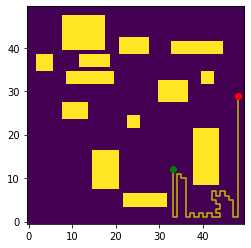

Number of steps taken in pred Path 101


In [77]:
# Test
pred_len = []
astar_len = []
n_test = 0
while n_test < 1:
    # TODO: Generalize to any map shape
    start = (random.randint(1,49), random.randint(1,49))
    goal = (random.randint(1,49), random.randint(1,49))
    arr, test_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    # If path is available, get test info
    try:
        pred_path = test_on_new_map(test_MAP, arr, start, goal, clf)
        OccupancyGridMap(arr, 1).plot()
        plot_path(pred_path)
        pred_len.append(len(pred_path))
        print('Number of steps taken in pred Path', len(pred_path))
        astar_len.append(len(get_path(start, goal, arr, False)))
        n_test += 1
    except:
        # No path found
        continue

In [245]:
def plot_path_with_lines(pred_path, MAP):
    '''
    Given predicted path nodes and map, 
    plot the path and the sensor readings for each node
    '''
    # Update node positions for shapely plotting
    pred_path = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
    # Save filenames for GIF creation
    filenames=[]
    for i, node in enumerate(pred_path):
        # Create fig
        fig = plt.figure(frameon=False)
        fig.set_size_inches(6,6)
        plt.plot(*LineString(pred_path).xy)
        plt.scatter(*node, s=30, alpha=1.0)
        # Get lines from sensor 
        _, lines = synthetic_sensor(MAP, node)
        for index, l in enumerate(MAP): 
            if index != 0:
                plt.fill(*l.xy, alpha=1)
            else:
                plt.plot(*l.xy, alpha=1)
        for k, line in enumerate(lines):
            plt.plot(*line.xy, alpha=0.25)
        filenames.append('img_{}.png'.format(i))
        plt.savefig('img_{}.png'.format(i))
        plt.close()
    
    # Make GIF
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('demo.gif', images)
        
plot_path_with_lines(pred_path, test_MAP)

In [244]:
# DL Solution ... not currently learning. 

import torch
class SensorData(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.mms = MinMaxScaler()
        self.mms.fit(df.drop('out', axis=1).values)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        x = self.mms.transform(sample.drop('out').values.astype(np.float32).reshape(1,-1))
        y = sample['out']
        return (torch.from_numpy(x).double(), y)
    
ds = SensorData(df)
train_loader = torch.utils.data.DataLoader(ds,64,True, num_workers=0, pin_memory=True)

from resnet1d import ResNet1D
model = ResNet1D(1,64,3,3,1,24,4).cuda()

from tqdm.notebook import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

loss = 0
for i in range(20):
    ep_loss = 0
    for batch in tqdm(train_loader):
        model.train()
        x,y = batch[0].cuda().float(), batch[1].cuda()

        optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out,y.long())
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
        
    print(ep_loss/len(train_loader))
        

NameError: name 'nn' is not defined